# land parcel simulations

In [35]:
import sys,os,random,time,string
import subprocess
import math
from importlib import reload
import numpy as np
import pandas as pd
import pylab as plt
import geopandas as gpd
import networkx as nx

In [36]:
def random_points(n, bounds=[10,10,1000,1000], seed=None):
    """Random points"""

    np.random.seed(seed)
    points = []    
    minx, miny, maxx, maxy = bounds
    x = np.random.uniform( minx, maxx, n)
    y = np.random.uniform( miny, maxy, n)
    return x, y

def random_geodataframe(n, bounds=[10,10,1000,1000], seed=None):
    """Random geodataframe of points"""

    x,y = random_points(n, bounds, seed)
    df = pd.DataFrame()
    df['geometry'] = list(zip(x,y))
    df['geometry'] = df['geometry'].apply(Point)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf['ID'] = range(n)
    return gdf

def random_hex_color():
    """random hex color"""

    r = lambda: np.random.randint(0,255)
    c='#%02X%02X%02X' % (r(),r(),r())
    return c

def random_hex_colors(n=1,seed=None):
    if seed != None:
        np.random.seed(seed)
    return [random_hex_color() for i in range(n)]

def get_short_uid(n=10):
    """Short uids up to n chars long"""

    import hashlib
    import base64
    # Generate a unique hash value using the current time and random bytes
    hash_value = hashlib.sha256(f"{time.time()}:{os.urandom(16)}".encode()).digest()
    # Encode the hash value using base64 without padding characters
    encoded_value = base64.b64encode(hash_value, altchars=b"-_").rstrip(b"=")
    # Convert the bytes to a string
    uid = encoded_value.decode("ascii")[:n]
    return uid

def get_largest_poly(x):
    if type(x) is MultiPolygon:
        return max(x.geoms, key=lambda a: a.area)
    else:
        return x
    
def count_fragments(x):
    if type(x) is MultiPolygon:
        return len(x.geoms)
    else:
        return 1

## making network from points

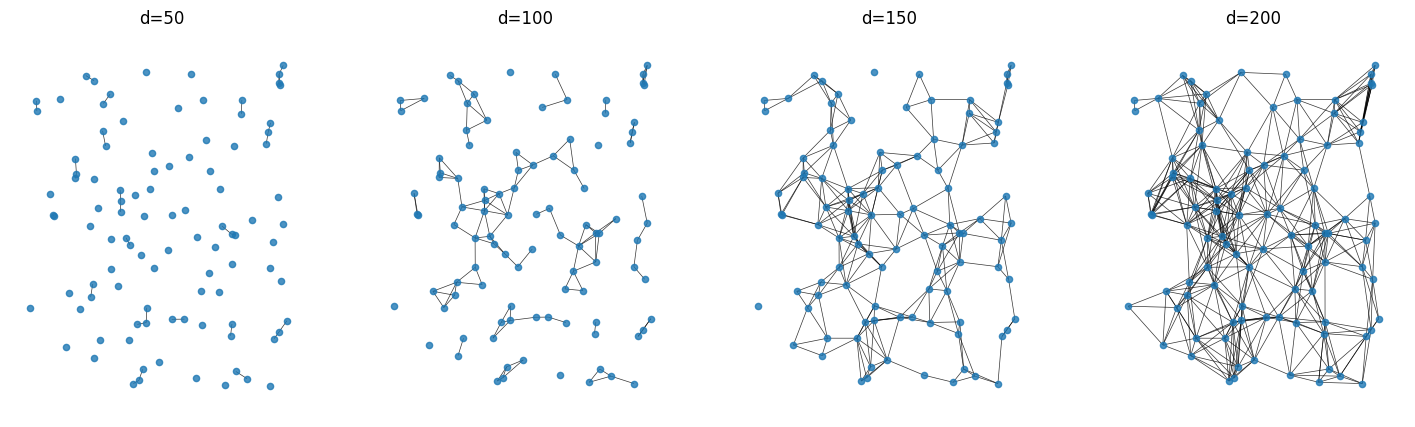

In [48]:
gdf = random_geodataframe(100, bounds=[1,1,1000,1000])
fig,ax=plt.subplots(1,4,figsize=(18,5))
axs=ax.flat
i=0
for d in [50,100,150,200]:
    G,pos = geodataframe_to_graph(gdf, d=d)
    nx.draw(G,pos,node_size=20,width=0.5,alpha=0.8,ax=axs[i])
    axs[i].set_title('d=%s' %d)
    i+=1

## simulate land parcels

In [21]:
def generate_land_parcels(cells=100,herds=10,empty=0,fragments=0,seed=None):
    """
    Simulate land parcels with fragmentation.
    Args:
        cells: number of points to make initial cell polyons
        herds: number of farms
        empty: fraction of fragments that are empty
        fragments: number of empty cells to add back as fragments
    """

    from shapely.geometry import Point,MultiPoint,MultiPolygon,Polygon
    from libpysal import weights, examples
    from libpysal.cg import voronoi_frames
    from sklearn.cluster import KMeans

    n = cells
    k = herds
    if seed != None:
        np.random.seed(seed)
    x,y = np.random.randint(1,1000,n),np.random.randint(1,1000,n)
    coords = np.column_stack((x, y))
    cells, generators = voronoi_frames(coords, clip="extent")
    centroids = cells.geometry.centroid
    #cluster parcels into 'herds'
    kmeans = KMeans(n_clusters=k,n_init='auto').fit(coords)
    cells['cluster'] = kmeans.labels_

    #remove some proportion of cells randomly
    e = cells.sample(frac=empty, random_state=seed)
    cells.loc[e.index,'cluster'] = 'empty'

    #create new GeoDataFrame
    poly=[]
    data = {'cluster':[]}
    for c,g in cells.groupby('cluster'):
        if c == 'empty':
            continue
        poly.append(MultiPolygon(list(g.geometry)))
        data['cluster'].append(c)
    farms = gpd.GeoDataFrame(data=data,geometry=poly)

    #merge contiguous fragments of same herd
    farms = farms.dissolve(by='cluster').reset_index()
    #remove polygons with 'holes'
    def no_holes(x):
        if type(x) is MultiPolygon:
            return MultiPolygon(Polygon(p.exterior) for p in x.geoms)
        else:
            return Polygon(x.exterior)
    farms.geometry = farms.geometry.apply(no_holes)
    #print (farms)

    #remove empty cells inside parcels
    e = e[e.within(farms.unary_union)==False]

    #assign some of the empty cells as fragments
    for i,r in cells.loc[e.index].sample(fragments).iterrows():
        #print (i)
        poly = farms.iloc[0].geometry
        if type(poly) is MultiPolygon:
            geom = poly.geoms
            new = MultiPolygon(list(geom) + [r.geometry])
        else:
            geom = poly
            new = MultiPolygon([geom,r.geometry])
        farms.loc[0,'geometry'] = new

    #merge contiguous fragments again in case we added fragments
    farms = farms.dissolve(by='cluster').reset_index()

    farms['herd'] = farms.apply(lambda x: get_short_uid(4),1)
    farms['fragments'] = farms.geometry.apply(count_fragments)
    farms['color'] = random_hex_colors(len(farms),seed=seed)
    return farms

In [27]:
def geodataframe_to_graph(gdf, key=None, attrs=[], d=200):
    """Convert geodataframe to graph with edges at distance threshold"""

    from scipy.spatial import distance_matrix

    cent= gdf.geometry.values
    coords = [(i.x,i.y) for i in cent]
    distances = distance_matrix(coords,coords)

    # Create an empty graph
    G = nx.Graph()
    for i in range(len(gdf)):
        G.add_node(i, pos=cent[i])
    # Loop through all pairs of centroids
    for i in range(len(gdf)):
        for j in range(i+1, len(gdf)):
            if distances[i][j] <= d:
                G.add_edge(i, j, weight=distances[i][j])

    pos = dict(zip(G.nodes, coords))
    nx.set_node_attributes(G, pos, 'pos')
    #rename nodes
    if key != None:
        mapping = dict(zip(G.nodes,gdf[key]))
        #print (mapping)
        G = nx.relabel_nodes(G, mapping)
    for col in attrs:
        vals = dict(zip(G.nodes, gdf[col]))
        nx.set_node_attributes(G, vals, col)
    return G,pos

## vary parameters

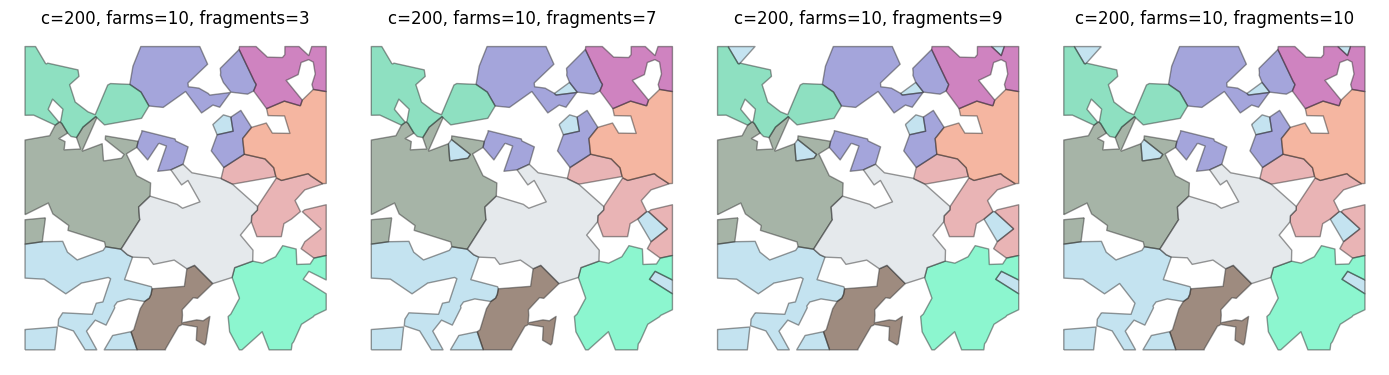

In [28]:
from shapely.geometry import Point,MultiPoint,MultiPolygon,Polygon
fig,ax=plt.subplots(1,4,figsize=(14,5))
axs=ax.flat
i=0
c=200
f=10
#for c in np.arange(40,320,80):
#for e in [0,0.2,0.6,0.8]:
for frags in [3,7,9,10]:
    #f=int(c/8)
    farms = generate_land_parcels(c,f,empty=0.4,seed=6,fragments=frags) 
    farms.plot(color=farms.color,ec='.2',alpha=0.5,ax=axs[i])#,legend=True)  #cmap='Paired'
    axs[i].set_title('c=%s, farms=%s, fragments=%s' %(c,f,frags))
    axs[i].axis('off')
    i+=1
plt.tight_layout()

## get contact network from parcels

In [31]:
def contiguous_parcels(parcels):
    """Get all contiguous parcels. Returns dict of indexes"""

    res = {}
    for i,r in parcels.iterrows():
        #print (r.herd)
        polygon = r.geometry
        spatial_index = parcels.sindex
        possible_matches_index = list(spatial_index.intersection(polygon.bounds))
        possible_matches = parcels.iloc[possible_matches_index]
        x = possible_matches[possible_matches.intersects(polygon)]
        #if len(x)>1:
        res[i] = list(x.index)
    return res

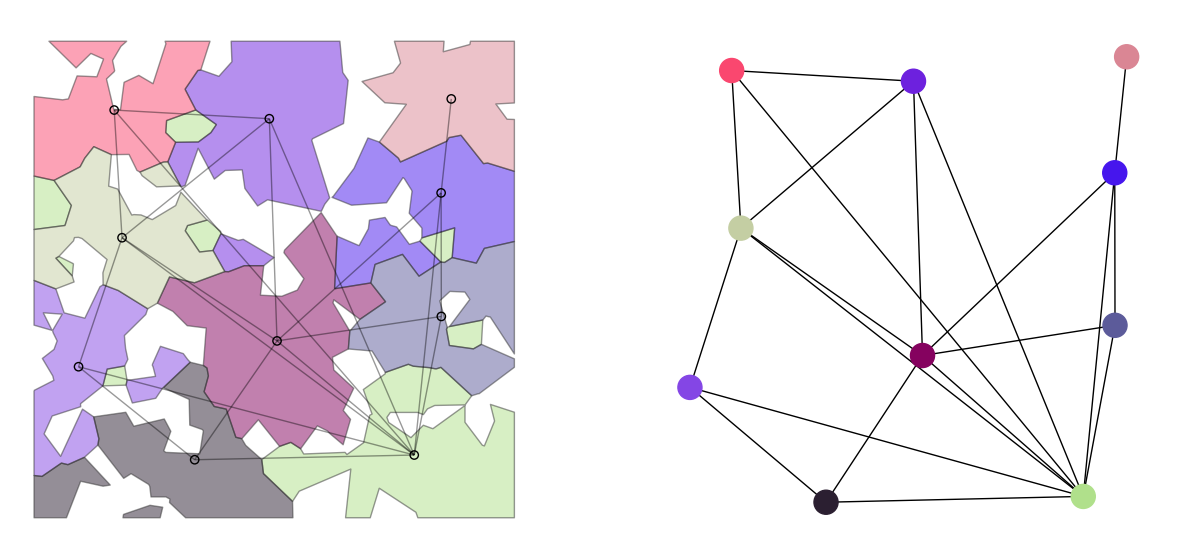

In [33]:
farms = generate_land_parcels(300,10,empty=.3,fragments=10,seed=50)
fig,ax=plt.subplots(1,2,figsize=(15,7))
axs=ax.flat
ax=axs[0]
farms.plot(color=farms.color,ec='.2',alpha=0.5,ax=ax)#,legend=True)cmap='Paired'
ax.axis('off')

#get cents
larg = farms.geometry.apply(get_largest_poly)
cent = gpd.GeoDataFrame(data=farms.copy(),geometry=larg.geometry.centroid)
cent.plot(color='none',ec='black',ax=ax)
cent['loc_type']='cow'

#make network graph

G,pos = geodataframe_to_graph(cent, d=300, attrs=['loc_type','herd'])

cont = contiguous_parcels(farms)
#print (cont)
#add egdes where nodes have contiguous parcels
for n in G.nodes:
    #print (n,G.nodes[n])   
    #print(nx.get_node_attributes(G,n))
    if n not in cont: 
        continue
    for j in cont[n]:
        if j!=n:
            G.add_edge(n,j)
#add more egdes for setts if near any other parcels

nx.draw(G,pos,node_size=0,alpha=0.4,ax=ax)
nx.draw(G,pos,node_color=farms.color,ax=axs[1])
#farms.fragments.hist(grid=False,ax=ax[2])